<a href="https://colab.research.google.com/github/AlEXSH3N/713-Music-Emotion-System/blob/main/713_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For GPU only

In [22]:
!pip install accelerate optimum

   ---------------------------------------- 0.0/302.4 kB ? eta -:--:--
   ------------------------------------- -- 286.7/302.4 kB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 302.4/302.4 kB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/417.0 kB ? eta -:--:--
   ---------------------------------- ----- 358.4/417.0 kB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 417.0/417.0 kB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   ---------------------------------------- 46.0/46.0 kB ? eta 0:00:00
   ---------------------------------------- 0.0/542.0 kB ? eta -:--:--
   ----------------------- ---------------- 317.4/542.0 kB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 542.0/542.0 kB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ------------

In [2]:
!pip install emoji
!pip install gensim
!pip install nltk
!pip install transformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gensim
import warnings
import string
import emoji
import re
import nltk
import torch
nltk.download('punkt')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Concatenate, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from transformers import BertTokenizer, BertForSequenceClassification

from torch.nn import BCEWithLogitsLoss

from optimum.bettertransformer import BetterTransformer
# from cuml.neighbors import KNeighborsClassifier
# from cuml.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading

In [8]:
# /content/drive/Shareddrives/713 Group Project/Dataset/
goemo1 = pd.read_csv(r'goemotions_1.csv')
goemo2 = pd.read_csv(r'goemotions_2.csv')
goemo3 = pd.read_csv(r'goemotions_3.csv')
goemo_all = pd.concat([goemo1, goemo2, goemo3], ignore_index=True)

print(len(goemo1), len(goemo2), len(goemo3), len(goemo_all))

70000 70000 71225 211225


In [ ]:
goemo_all.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


## Data Exploration

In [9]:
emotion_initial_index = goemo_all.columns.tolist().index('admiration')
labels = goemo_all.columns.tolist()[emotion_initial_index:]
print(f"{labels} \n{len(labels)}")

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'] 
28


In [ ]:
no_text_more_than_50 = 0
for text in goemo_all['text']:
    if len(text) > 50:
        no_text_more_than_50 += 1
print(f"Number of texts with more than 50 characters: {no_text_more_than_50}: {no_text_more_than_50/len(goemo_all)*100}%")

Number of texts with more than 50 characters: 136658: 64.69783406320275%


In [52]:
vec = CountVectorizer()
X = vec.fit_transform(goemo_all['text'])

words = vec.get_feature_names_out()
word_frequncies = X.toarray().sum(axis=0)
word_freq_dict = dict(zip(words, word_frequncies))

sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_words[:20])

[('the', 88552), ('to', 62720), ('you', 55798), ('it', 53496), ('that', 47689), ('and', 44440), ('is', 41295), ('name', 38233), ('of', 35196), ('this', 31946), ('in', 28568), ('for', 27557), ('was', 19223), ('my', 18801), ('not', 18722), ('but', 17991), ('be', 17842), ('on', 17484), ('just', 17219), ('have', 16763)]


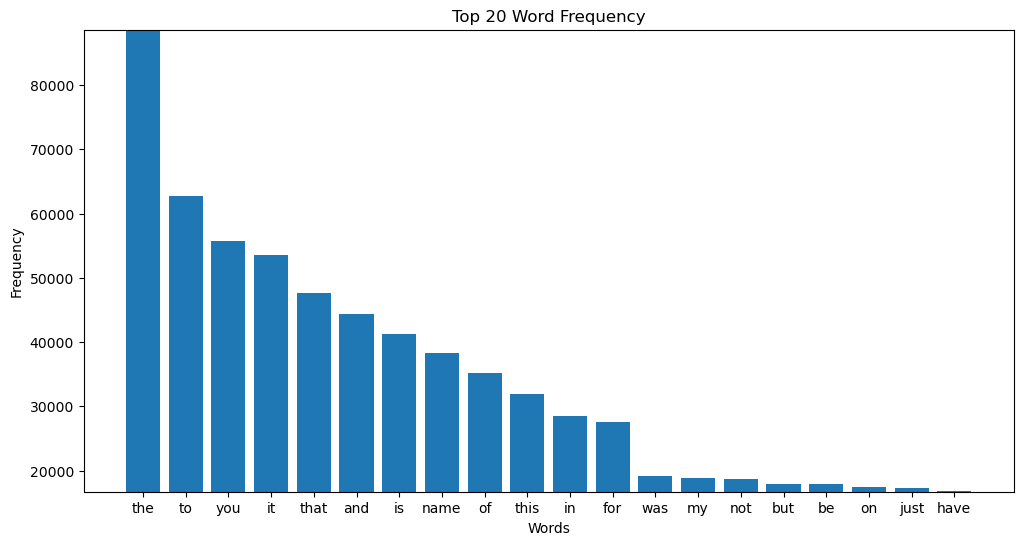

In [51]:
top_20_words = sorted_words[:20]
words, frequencies = zip(*top_20_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequency')
plt.ylim(frequencies[-1] - 50, frequencies[0] + 50)
plt.show()

In [ ]:
def count_punctuation(text):
    punctuations = string.punctuation
    concatenated = " ".join(text)
    punctuation_count = {}
    for char in concatenated:
        if char in punctuations:
            if char in punctuation_count:
                punctuation_count[char] += 1
            else:
                punctuation_count[char] = 1
    return punctuation_count

punctuation_count = count_punctuation(goemo_all["text"])
print(punctuation_count)


{'.': 229770, '>': 3348, '"': 12086, ',': 69932, "'": 73015, '!': 41885, '[': 37848, ']': 37831, '?': 25849, ';': 988, '/': 6151, '-': 9591, '<': 529, '$': 834, '(': 4325, ')': 5809, '#': 845, ':': 7648, '*': 9585, '_': 690, '|': 456, '%': 1022, '+': 593, '&': 403, '~': 1086, '^': 1646, '=': 461, '`': 25, '@': 138, '\\': 44, '{': 9, '}': 18}


In [ ]:
num_names_list = [text.count('[NAME]') for text in goemo_all['text']]
num_names_list = list(filter(lambda x: x >= 5, num_names_list))
print(len(num_names_list))

77


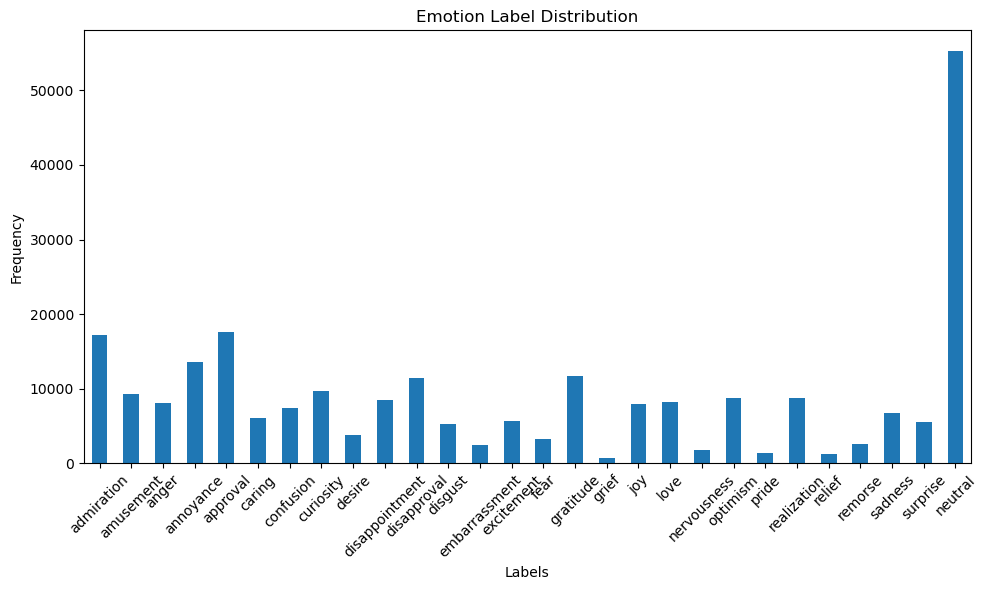

In [24]:
emotion_label_distribution = goemo_all[labels].sum()

plt.figure(figsize=(10, 6))
emotion_label_distribution.plot(kind='bar')
plt.title('Emotion Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
label_distribution_series = pd.Series(emotion_label_distribution, index=labels)
label_distribution_series_sorted = label_distribution_series.sort_values(ascending=False)

print("Label Distribution:")
print(label_distribution_series_sorted)

Label Distribution:
neutral           55298
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


## Data Preprocessing

### Data Cleaning

In [26]:
necessary_features_to_keep = goemo_all.columns[:1].append(goemo_all.columns[emotion_initial_index:])
goemo_all_selected = goemo_all[necessary_features_to_keep]

In [27]:
label_columns = goemo_all_selected.columns[1:]
neutral_rows = goemo_all_selected[(goemo_all_selected['neutral'] == 1) & (goemo_all_selected[label_columns].sum(axis=1) > 1)]
count_neutral_more_than_1 = len(neutral_rows)

print("Number of rows where 'neutral' is 1 and total labels > 1:", count_neutral_more_than_1)

Number of rows where 'neutral' is 1 and total labels > 1: 0


In [28]:
neutral_indices = np.random.choice(goemo_all_selected[goemo_all_selected['neutral'] == 1].index, size=(label_distribution_series_sorted[0] - label_distribution_series_sorted[1]), replace=False)
geomo_all_neutral_undersampled = goemo_all_selected.drop(neutral_indices)

C:\Users\Alex\AppData\Local\Temp\ipykernel_32352\3537354743.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neutral_indices = np.random.choice(goemo_all_selected[goemo_all_selected['neutral'] == 1].index, size=(label_distribution_series_sorted[0] - label_distribution_series_sorted[1]), replace=False)


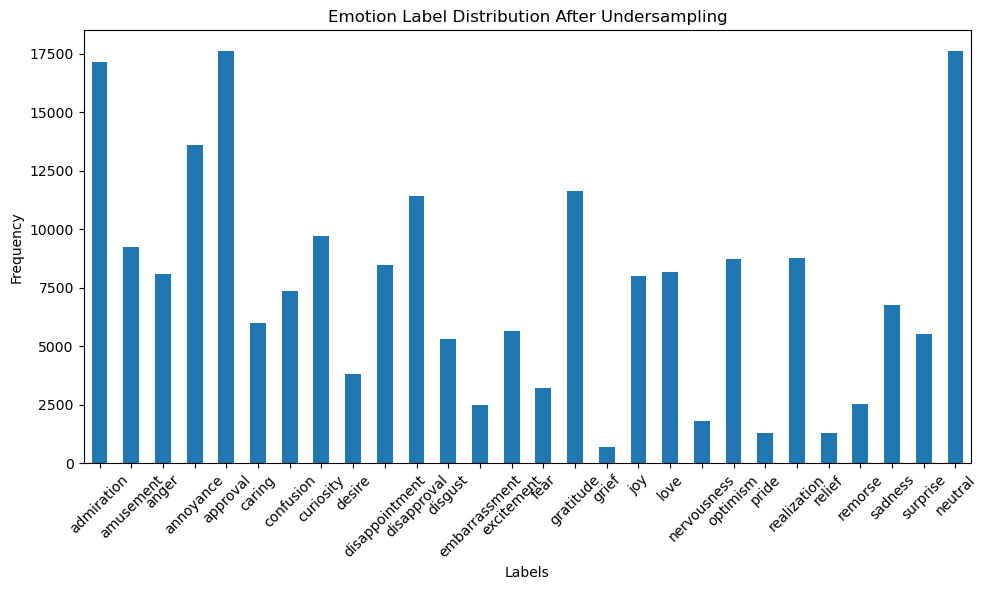

In [29]:
emotion_label_undersampled_distribution = geomo_all_neutral_undersampled[labels].sum()

plt.figure(figsize=(10, 6))
emotion_label_undersampled_distribution.plot(kind='bar')
plt.title('Emotion Label Distribution After Undersampling')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
emotion_label_distribution_undersampled = geomo_all_neutral_undersampled[labels].sum()
label_distribution_undersampled_series = pd.Series(emotion_label_distribution_undersampled, index=labels)
label_distribution_undersampled_series_sorted = label_distribution_undersampled_series.sort_values(ascending=False)

print("Label Distribution:")
print(label_distribution_undersampled_series_sorted)

Label Distribution:
neutral           17620
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


In [31]:
print(len(geomo_all_neutral_undersampled))

173547


In [32]:
contraction_mapping = {'u.s':'america', 'e.g.':'for example', 'e.g': "for example", 'dont': "do not"}
remove_words = ["they", "she", "need", "there", "this", "that", "those", "these", "should", "about",
                "could", "ought", "would", "will", "have", "has", "had", "might", "may", "sha", "your",
                "shall", "must", "are", "were", "was", "does", "did", "how", "who", "why", "for", "with",
                "what", "where", "when", "whose", "whom", "ain", "theyve", "Ive", "you", "and", "thats",
                "theyre", "shes", "hes", "werent", "wasnt", "yall", "theirs", "yours", "his", "the",
                "her", "hers", "him", "their", "them", "mine", "maam", "its", ""]
exception_two_words = ["yo", "ew", "ya", "um", "oh", "ok", "eh", "aw", "hi", "ho", "ay", "ai",
                       "em", "if", "lo", "in", "op", "uh", "um", "ye"]
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization', "arent": "are not", "isnt": "is not", "aint": "not",  'coz': 'because', 'therefore': 'so', 'thus': 'so', 'hence': 'so'}
# t --> before cancel
# if t before is a can --> cannot
# remove single letter


In [33]:
def remove_name(text):
  return text.replace('[NAME]', '')

def replace_emoji_text(text):
  return emoji.demojize(text, delimiters=("", ""))

def contraction_mapping_fun(text):
  word_list = text.split(" ")
  length = len(word_list)

  for i in range(length - 1, -1, -1):
    word = word_list[i]
    if word == "":
      continue
    word = word.lower()
    if word == "t" and i > 0:
      if word_list[i-1] == "can":
        word_list[i-1] = "cannot"
      else:
        word_list[i] = "not"
        word_list[i-1] = ""
    elif len(word) <= 2 and word not in exception_two_words:
      word_list[i] = ""
    elif word in remove_words:
      word_list[i] = ""

  text = ' '.join(map(str, word_list))
  return text

def mispelled_word(text):
  word_list = text.split(" ")
  length = len(word_list)
  for i in range(length - 1, -1, -1):
    word = word_list[i].lower()
    if word in mispell_dict:
      word_list[i] = mispell_dict[word]

  text = ' '.join(map(str, word_list))
  return text

def retain_english_text(text):
  word_list = text.split(" ")
  for i in range(len(word_list)):
    ele = word_list[i].lower()
    if ele in contraction_mapping:
      word_list[i] = contraction_mapping[ele]

  text = ' '.join(map(str, word_list))
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = mispelled_word(text)
  text = contraction_mapping_fun(text)
  return text

def data_cleaning_pipeline(text):
  text = remove_name(text)
  text = replace_emoji_text(text)
  text = retain_english_text(text)
  text = " ".join(text.split())
  return text

In [34]:
geomo_all_neutral_undersampled['text'] = geomo_all_neutral_undersampled['text'].apply(data_cleaning_pipeline)

In [35]:
geomo_all_neutral_undersampled.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,game hurt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality shouldnt grouping category makes dif...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Man love reddit,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,Right Considering such important document know...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,not big but still quite popular Ive heard the ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def count_short_strings(df):
    return ((df['text'].str.len() == 0) | (df['text'].str.len() == 1)).sum()

# Example usage
short_string_count = count_short_strings(geomo_all_neutral_undersampled)
print("Number of rows with text of length 0 or 1:", short_string_count)

Number of rows with text of length 0 or 1: 313


In [36]:
split_texts = geomo_all_neutral_undersampled['text'].str.split()
word_counts = split_texts.apply(len)
indices = word_counts[word_counts > 1].index

In [ ]:
less_than_two = word_counts[word_counts <= 1].count()
print(f'Rows with word count <= 1: {less_than_two}')

Rows with word count <= 1: 4741


In [37]:
geomo_all_neutral_undersampled = geomo_all_neutral_undersampled.loc[indices]
geomo_all_neutral_undersampled.reset_index(drop=True, inplace=True)
print(f'Number of rows: {len(geomo_all_neutral_undersampled)}')

Number of rows: 168806


In [46]:
vec_cleaned = CountVectorizer()
X_cleaned = vec_cleaned.fit_transform(geomo_all_neutral_undersampled['text'])

words_cleaned = vec_cleaned.get_feature_names_out()
word_frequncies_cleaned = X_cleaned.toarray().sum(axis=0)
words_freq_dict = dict(zip(words_cleaned, word_frequncies_cleaned))

sorted_words_cleaned = sorted(words_freq_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_words_cleaned)

[('the', 71792), ('and', 36211), ('for', 23222), ('in', 22873), ('not', 18300), ('but', 15020), ('just', 14126), ('like', 13527), ('with', 12775), ('your', 10989), ('dont', 9987), ('if', 9760), ('about', 8028), ('all', 7981), ('love', 7697), ('thats', 7620), ('get', 7486), ('good', 7475), ('one', 7354), ('people', 6953), ('can', 6832), ('out', 6582), ('really', 6195), ('know', 5908), ('think', 5864), ('too', 5756), ('from', 5754), ('or', 5743), ('more', 5535), ('youre', 5071), ('now', 5021), ('thanks', 5008), ('lol', 4879), ('time', 4728), ('some', 4698), ('see', 4683), ('because', 4511), ('much', 4156), ('thank', 4072), ('even', 4062), ('well', 4045), ('oh', 3926), ('still', 3921), ('been', 3903), ('cant', 3846), ('got', 3755), ('only', 3700), ('didnt', 3672), ('right', 3631), ('here', 3620), ('never', 3546), ('than', 3509), ('bad', 3504), ('being', 3503), ('want', 3477), ('yeah', 3422), ('make', 3402), ('ive', 3377), ('way', 3370), ('very', 3329), ('then', 3284), ('sorry', 3275), ('f

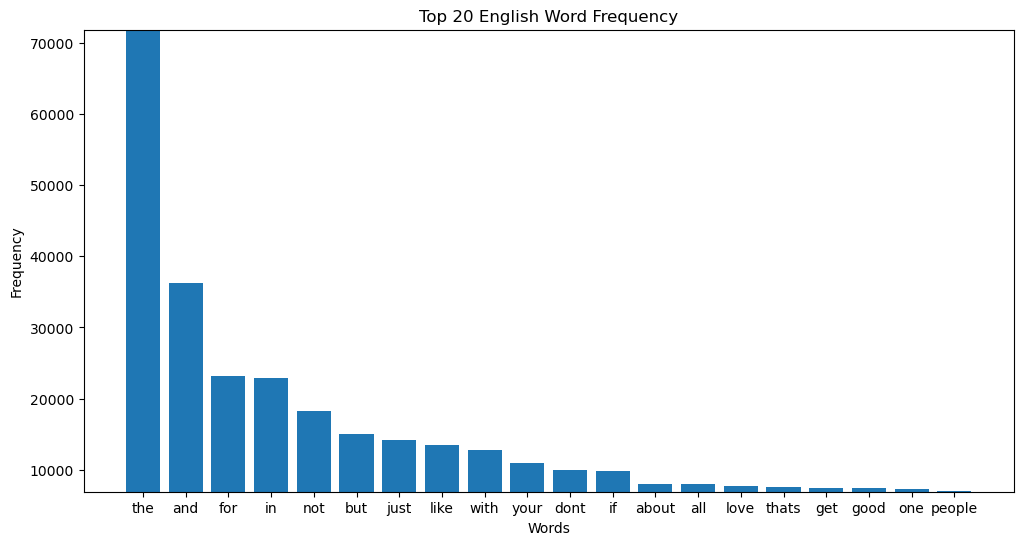

In [47]:
top_20_words_cleaned = sorted_words_cleaned[:20]
words_cleaned, frequencies_cleaned = zip(*top_20_words_cleaned)

plt.figure(figsize=(12, 6))
plt.bar(words_cleaned, frequencies_cleaned)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 English Word Frequency')
plt.ylim(frequencies_cleaned[-1] - 50, frequencies_cleaned[0] + 50)
plt.show()

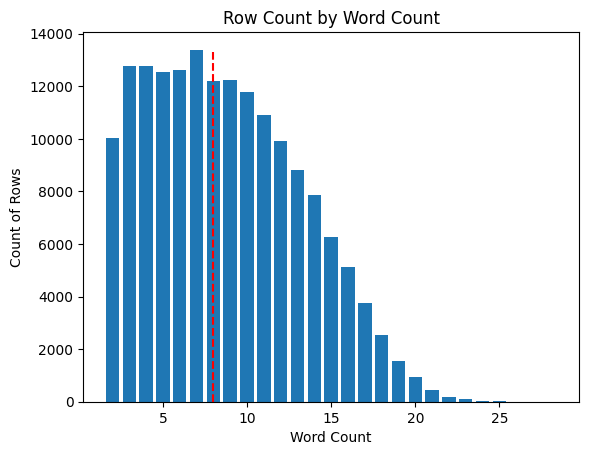

In [ ]:
word_counts = pd.DataFrame()
word_counts['count'] = geomo_all_neutral_undersampled['text'].apply(lambda x: len(x.split()))
word_counts = word_counts.sort_values('count', ascending=False)

counts = word_counts['count'].value_counts()
median = word_counts['count'].median()

plt.bar(counts.index, counts)
plt.ylabel('Count of Rows')
plt.xlabel('Word Count')
plt.title('Row Count by Word Count')
plt.plot([median, median], [0, counts.max()], color='r', linestyle='--')

plt.show()

In [38]:
full_train_data, test_data = train_test_split(geomo_all_neutral_undersampled, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(full_train_data, test_size=0.25, random_state=42)

In [39]:
y_train = train_data[labels].values
y_val = val_data[labels].values
y_test = test_data[labels].values
y_full_train = full_train_data[labels].values

In [40]:
X_full_train = full_train_data.iloc[:, 0].values
X_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 0].values
X_val = val_data.iloc[:, 0].values

### Word Tokenizer

### Traditional ML

In [41]:
tokenizer = nltk.word_tokenize

tokenized_texts_full_train = [tokenizer(text) for text in X_full_train]
tokenized_texts_train = [tokenizer(text) for text in X_train]
tokenized_texts_test = [tokenizer(text) for text in X_test]
tokenized_texts_val = [tokenizer(text) for text in X_val]

w2v_model = gensim.models.Word2Vec(tokenized_texts_train, vector_size=100, window=5, min_count=1, workers=4)


In [42]:
full_train_word_vectors = [np.mean([w2v_model.wv[w] for w in tokens if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for tokens in tokenized_texts_full_train]
train_word_vectors = [np.mean([w2v_model.wv[w] for w in tokens if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for tokens in tokenized_texts_train]
test_word_vectors = [np.mean([w2v_model.wv[w] for w in tokens if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for tokens in tokenized_texts_test]
val_word_vectors = [np.mean([w2v_model.wv[w] for w in tokens if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for tokens in tokenized_texts_val]

In [ ]:
print(len(X_train[0]), len(train_word_vectors[0]), len(test_word_vectors[0]), len(val_word_vectors[0]))

44 100 100 100


### Transformer

In [43]:
flat_tokens_train = [tok for text in tokenized_texts_train for tok in text]
flat_tokens_val = [tok for text in tokenized_texts_val for tok in text]
flat_tokens_test = [tok for text in tokenized_texts_test for tok in text]
flat_tokens_full_train = [tok for text in tokenized_texts_full_train for tok in text]

In [44]:
all_texts = flat_tokens_train + flat_tokens_val + flat_tokens_test
transformer_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encoded = transformer_tokenizer(
  all_texts,
  padding=True,
  truncation=True,
  return_tensors="pt",
  return_attention_mask=True
)

encoded_train = {
    "input_ids": encoded["input_ids"][:len(flat_tokens_train)],
    "attention_mask": encoded["attention_mask"][:len(flat_tokens_train)]
}

encoded_val = {
  "input_ids": encoded["input_ids"][len(flat_tokens_train):len(flat_tokens_train)+len(flat_tokens_val)],
  "attention_mask": encoded["attention_mask"][len(flat_tokens_train):len(flat_tokens_train)+len(flat_tokens_val)]
}

encoded_test = {
  "input_ids": encoded["input_ids"][len(flat_tokens_train)+len(flat_tokens_val):],
  "attention_mask": encoded["attention_mask"][len(flat_tokens_train)+len(flat_tokens_val):]
}

encoded_full_train = {
  "input_ids": encoded["input_ids"][:len(flat_tokens_train)+len(flat_tokens_val)],
  "attention_mask": encoded["attention_mask"][:len(flat_tokens_train)+len(flat_tokens_val)]
}

c:\Users\Alex\miniconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alex\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# max_len = geomo_all_neutral_undersampled['text'].str.len().max()

# def tokenizer_and_pad_sequences(data, max_len):
#     tokenizer = Tokenizer()
#     tokenizer.fit_on_texts(data['text'])
#     sequences = tokenizer.texts_to_sequences(data['text'])
#     padded_sequences = pad_sequences(sequences, maxlen=max_len)
#     return tokenizer, padded_sequences

# tokenizer, padded_sequences_train = tokenizer_and_pad_sequences(train_data, max_len)
# _, padded_sequences_val = tokenizer_and_pad_sequences(val_data, max_len)
# _, padded_sequences_test = tokenizer_and_pad_sequences(test_data, max_len)
# _, padded_sequences_all = tokenizer_and_pad_sequences(full_train_data, max_len)

In [ ]:
# tokenized_texts_train = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_train]
# tokenized_texts_val = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_val]
# tokenized_texts_test = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_test]
# tokenized_texts_full = [tokenizer.sequences_to_texts([sequence])[0].split() for sequence in padded_sequences_all]

In [ ]:
# tokenized_texts = tokenized_texts_train + tokenized_texts_val + tokenized_texts_test
# model = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# tfidf = TfidfVectorizer(tokenizer=tokenizer)
# tfidf_matrix = tfidf.fit_transform(X_train)
# weighted_train_vectors = [np.sum(tfidf_matrix[i].multiply(train_word_vectors[i]), axis=0) for i in range(len(X_train))]

In [ ]:
# def create_sentence_embeddings(tokenized_texts, model):
#     sentence_embeddings = []
#     for text in tokenized_texts:
#         word_vectors = [model.wv[word] for word in text if word in model.wv]
#         if word_vectors:
#             sentence_embeddings.append(sum(word_vectors) / len(word_vectors))
#         else:
#             sentence_embeddings.append([0] * model.vector_size)
#     return sentence_embeddings

# sentence_embeddings_train = create_sentence_embeddings(tokenized_texts_train, model)
# sentence_embeddings_val = create_sentence_embeddings(tokenized_texts_val, model)
# sentence_embeddings_test = create_sentence_embeddings(tokenized_texts_test, model)
# sentence_embeddings_full = create_sentence_embeddings(tokenized_texts_full, model)

In [ ]:
# X_train = np.array(sentence_embeddings_train)
# X_val = np.array(sentence_embeddings_val)
# X_test = np.array(sentence_embeddings_test)
# X_full_train = np.array(sentence_embeddings_full)

## Models

### Traditional ML

#### Logistic OVR

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_word_vectors)

log_ovr = OneVsRestClassifier(LogisticRegression(max_iter=10000)).fit(X_scaled, y_train)

In [ ]:
X_val_scaled = scaler.fit_transform(val_word_vectors)
score = log_ovr.score(X_val_scaled, y_val)
print('Validation score:', score)

Validation score: 0.06787544810831629


### Transformer

#### Bert

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels), device_map="auto")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)

In [ ]:
for epoch in range(10):
  outputs = bert_model(
      input_ids=encoded_train["input_ids"],
      attention_mask=encoded_train["attention_mask"]
  )
  loss = BCEWithLogitsLoss(outputs, y_train)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

In [ ]:
outputs = bert_model(**encoded_val)
preds = torch.sigmoid(outputs[0])

### Semi transformer

In [ ]:
def build_semi_transformer(vocab_size, max_len, embedding_dim, num_heads, hidden_dim, num_emotions, dropout_rate=0.1):
    inputs = Input(shape=(max_len,), name="input_ids")

    # Embedding layer
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="embedding")(inputs)

    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads)(x, x)
    attention_output = LayerNormalization()(attention_output + x)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Feed-forward layer
    ff_output = Dense(units=hidden_dim, activation="relu")(attention_output)
    ff_output = Dense(units=embedding_dim, activation="linear")(ff_output)
    ff_output = LayerNormalization()(ff_output + attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    # Pooling and classification
    pooled_output = Flatten()(ff_output)
    outputs = Dense(units=num_emotions, activation="sigmoid", name="output")(pooled_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# embedding_dim = 128
# embedding_dim = 128
# num_heads = 8
# hidden_dim = 256
# dropout_rate = 0.2
# num_emotions = len(labels)

# model = build_semi_transformer(vocab_size=len(tokenizer.word_index) + 1,
#                                max_len=max_len,
#                                embedding_dim=embedding_dim,
#                                num_heads=num_heads,
#                                hidden_dim=hidden_dim,
#                                num_emotions=num_emotions,
#                                dropout_rate=dropout_rate)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(padded_sequences_train, multi_labels_train, epochs=20, batch_size=32, validation_split=0.2)